In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('../Data Preprocessing/Finalized Out.csv')
df.tail(10)
df.columns = ['Series', 'Day', 'Day_of_Week', 'Time', 'Hour_of_Day', 'IsEJeep1',
       'IsEJeep2', 'IsEJeep3', 'Altitude', 'Humidity', 'Temperature',
       'Latitude', 'Longitude', 'Lat Diff', 'Long Diff', 'Distance',
       'Cum Distance', 'Abs Distance', 'Percent Distance', 'Encoded Station',
       'IsStation', 'IsCharging', 'Encoded Prev Station', 'Prev Station Lat',
       'Prev Station Long', 'Prev Abs Distance', 'Prev Cum Distance',
       'Previous Time to Xavier Hall', 'Previous Time to Fine Arts Annex',
       'Previous Time to Loyola House of Studies',
       'Previous Time to Grade School', 'Previous Time to Gate 2.5',
       'Previous Time to Leong Hall', 'Encoded Next Station',
       'Next Station Lat', 'Next Station Long', 'Next Time to Xavier Hall',
       'Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies',
       'Next Time to Grade School', 'Next Time to Gate 2.5',
       'Next Time to Leong Hall']
df.drop(columns=['Series'], inplace=True)

# df['Series'] = df['Series'] + 1
df

,Day,Day_of_Week,Time,Hour_of_Day,IsEJeep1,IsEJeep2,IsEJeep3,Altitude,Humidity,Temperature,...,Previous Time to Leong Hall,Encoded Next Station,Next Station Lat,Next Station Long,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
0,17,4,21600,6,1,0,0,63.7,79.199997,29.299999,...,-1.0,1.0,14.634715,121.076249,22682.0,24486.0,22905.0,21987.0,24948.0,22353.0
1,17,4,21601,6,1,0,0,63.5,79.199997,29.299999,...,-1.0,1.0,14.634715,121.076249,22682.0,24486.0,22905.0,21987.0,24948.0,22353.0
2,17,4,21602,6,1,0,0,63.3,79.199997,29.299999,...,-1.0,1.0,14.634715,121.076249,22682.0,24486.0,22905.0,21987.0,24948.0,22353.0
3,17,4,21603,6,1,0,0,63.0,79.199997,29.299999,...,-1.0,1.0,14.634715,121.076249,22682.0,24486.0,22905.0,21987.0,24948.0,22353.0
4,17,4,21604,6,1,0,0,62.7,79.199997,29.299999,...,-1.0,1.0,14.634715,121.076249,22682.0,24486.0,22905.0,21987.0,24948.0,22353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512132,12,6,64796,17,0,1,0,75.0,80.400002,30.799999,...,35202.0,5.0,14.640187,121.078520,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
512133,12,6,64797,17,0,1,0,75.0,80.400002,30.799999,...,35202.0,5.0,14.640187,121.078520,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
512134,12,6,64798,17,0,1,0,75.0,80.400002,30.799999,...,35202.0,5.0,14.640187,121.078520,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
512135,12,6,64799,17,0,1,0,75.0,80.400002,30.799999,...,35202.0,5.0,14.640187,121.078520,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [34]:
df = df.fillna(-1)

In [35]:
# split data into train-test set
train_df = df[df['Day'] < 16]
test_df = df[df['Day'] >= 16]
validation_df = df[df['Day'] < 17]

In [36]:
# Select features and targets
feature_columns = df.columns[:-6]
target_columns = df.columns[-6:]

# Separate features and targets into different lists
feature_df = df[feature_columns]
target_df = df[target_columns]

# Set the seed for reproducibility
np.random.seed(len(feature_columns))

In [37]:
# Define sequence length (number of past time steps to consider)
sequence_length = len(feature_columns)
num_targets = len(target_columns)

# Prepare sequences for training
train_sequences = []
test_sequences = []

for i in range(len(df) - sequence_length + 1):
    train_sequence = train_df.iloc[i:i+sequence_length].values
    test_sequence = test_df.iloc[i:i+sequence_length].values
    
    # Check if the lengths match
    if len(train_sequence) == sequence_length and len(test_sequence) == sequence_length:
        train_sequences.append(train_sequence)
        test_sequences.append(test_sequence)

In [38]:
# Convert the list of sequences to a NumPy array
train_sequences = np.array(train_sequences)
test_sequences = np.array(test_sequences)

# Ensure all sequences have the same length
# sequences = sequences[:len(sequences)//sequence_length * sequence_length]

# Convert the list of sequences to a NumPy array
# sequences = np.array(sequences)

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Step 3: Scale Data
scaler = MinMaxScaler()

# Fit the scaler on the training set
scaler.fit(train_sequences.reshape(-1, train_sequences.shape[-1]))

# Transform both the training and test sets using the fitted scaler
train_sequences_scaled = scaler.transform(train_sequences.reshape(-1, train_sequences.shape[-1])).reshape(train_sequences.shape)
test_sequences_scaled = scaler.transform(test_sequences.reshape(-1, test_sequences.shape[-1])).reshape(test_sequences.shape)

In [40]:
# Separate features and targets in the scaled sequences
X_train = train_sequences_scaled[:, :, :len(feature_columns)]  # X Features train
X_test = test_sequences_scaled[:, :, :len(feature_columns)]  # X Features test
y_train = train_sequences_scaled[:, :, len(feature_columns):]  # y Targets train
y_test = test_sequences_scaled[:, :, len(feature_columns):]  # y Targets test

In [41]:
# Define the Transformer model
def transformer_model(sequence_length, feature_dim, num_heads=2, ff_dim=32, key_dim=None, dropout=0.1):
    if key_dim is None:
        # Set a default value for key_dim (you can adjust this based on your preferences)
        key_dim = feature_dim // num_heads

    inputs = Input(shape=(sequence_length, feature_dim))

    # Multi-Head Self-Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feedforward Neural Network
    outputs = Dense(ff_dim, activation="relu")(attention)
    outputs = Dense(feature_dim)(outputs)
    outputs = Dropout(dropout)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

    # Output layer
    outputs = Dense(len(target_columns), activation="linear")(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
model = transformer_model(sequence_length, len(feature_columns))
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
5400/5400 - 74s - loss: 0.0107 - val_loss: 0.1894 - 74s/epoch - 14ms/step
Epoch 2/10
5400/5400 - 55s - loss: 0.0053 - val_loss: 0.1906 - 55s/epoch - 10ms/step
Epoch 3/10
5400/5400 - 55s - loss: 0.0038 - val_loss: 0.1652 - 55s/epoch - 10ms/step
Epoch 4/10
5400/5400 - 51s - loss: 0.0031 - val_loss: 0.1436 - 51s/epoch - 10ms/step
Epoch 5/10
5400/5400 - 55s - loss: 0.0026 - val_loss: 0.1419 - 55s/epoch - 10ms/step
Epoch 6/10
5400/5400 - 46s - loss: 0.0022 - val_loss: 0.1440 - 46s/epoch - 9ms/step
Epoch 7/10
5400/5400 - 47s - loss: 0.0020 - val_loss: 0.1590 - 47s/epoch - 9ms/step
Epoch 8/10
5400/5400 - 44s - loss: 0.0018 - val_loss: 0.1810 - 44s/epoch - 8ms/step
Epoch 9/10
5400/5400 - 72s - loss: 0.0017 - val_loss: 0.1818 - 72s/epoch - 13ms/step
Epoch 10/10
5400/5400 - 66s - loss: 0.0015 - val_loss: 0.1849 - 66s/epoch - 12ms/step


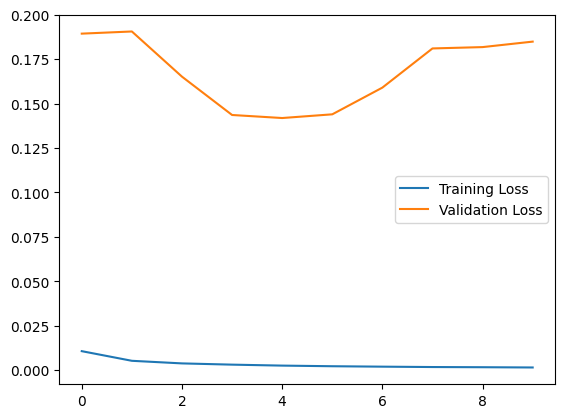

In [44]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

5400/5400 [==============================] - 32s 6ms/step


In [ ]:
y_pred

array([[[ 0.37428468,  0.42624745,  0.39556813,  0.39366078,
          0.37611645,  0.39645547],
        [ 0.3742787 ,  0.42624235,  0.39556384,  0.39365757,
          0.37611163,  0.39645737],
        [ 0.37427908,  0.42625034,  0.3955698 ,  0.3936611 ,
          0.37611833,  0.39645958],
        ...,
        [ 0.37424293,  0.42628375,  0.39559433,  0.39366668,
          0.37614328,  0.39649194],
        [ 0.37424117,  0.42628908,  0.3955978 ,  0.3936686 ,
          0.37614724,  0.39649504],
        [ 0.37422192,  0.42624986,  0.39556628,  0.3936452 ,
          0.37611377,  0.39649382]],

       [[ 0.3742781 ,  0.42624342,  0.3955643 ,  0.39365697,
          0.3761117 ,  0.39646178],
        [ 0.37427852,  0.4262514 ,  0.39557025,  0.3936606 ,
          0.37611842,  0.396464  ],
        [ 0.37427852,  0.42626035,  0.39557654,  0.39366418,
          0.37612566,  0.39646718],
        ...,
        [ 0.3742407 ,  0.42629027,  0.39559823,  0.39366812,
          0.3761474 ,  0.39649954],
  

In [ ]:
y_test

array([[[0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        ...,
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723]],

       [[0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        ...,
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.39482513,
         0.34874723],
        [0.35252156, 0.38081242, 0.35475777, 0.34528352, 0.394

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten the 3D arrays to 2D
flat_y_test = y_test.reshape(-1, y_test.shape[-1])
flat_y_pred = y_pred.reshape(-1, y_pred.shape[-1])

# Calculating MSE for all columns
rmse = mean_squared_error(flat_y_test, flat_y_pred, squared=False)

mae = mean_absolute_error(flat_y_test, flat_y_pred)

r2 = r2_score(flat_y_test, flat_y_pred)

print('With Next Time of Arrival in Train Dataset:')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'MAE: {mae}')

With Next Time of Arrival in Train Dataset:
RMSE: 0.4807643655733278
R^2: -4.487741485527593
MAE: 0.3828229259635243


/Users/anyahabana/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


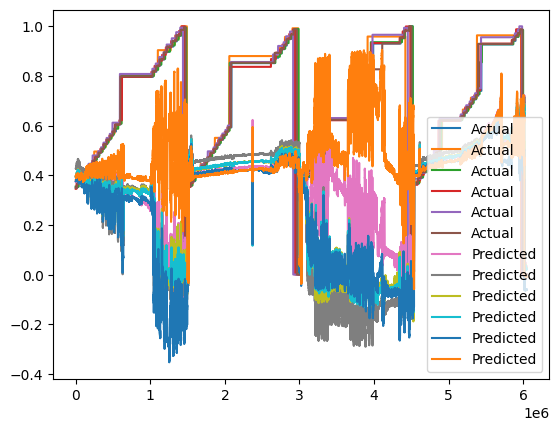

In [ ]:
# Plot 2D Actual vs. Predicted
plt.plot(flat_y_test, label='Actual')
plt.plot(flat_y_pred, label='Predicted')
plt.legend()
plt.show()

KeyboardInterrupt: 

/Users/anyahabana/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


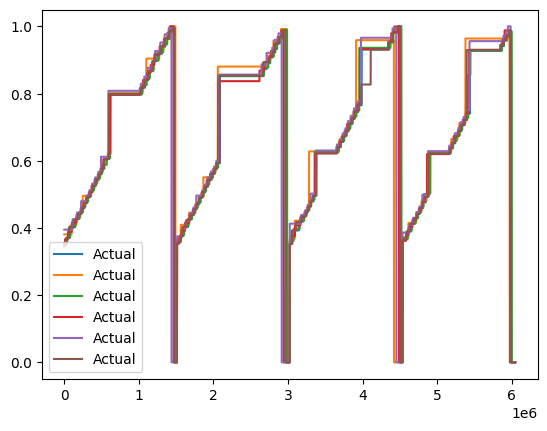

In [46]:
# Plot 2D Actual
plt.plot(flat_y_test, label='Actual')
plt.legend()
plt.show()

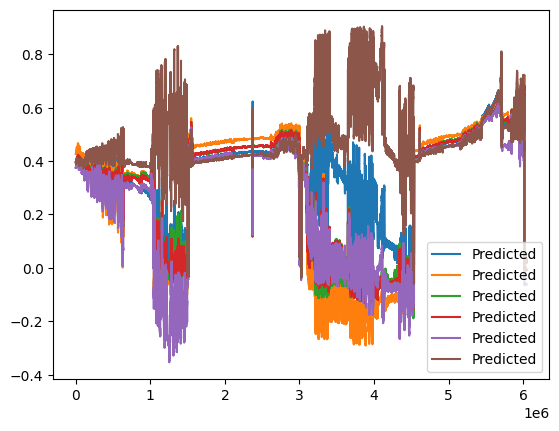

In [47]:
# Plot 2D Predicted
plt.plot(flat_y_pred, label='Predicted')
plt.legend()
plt.show()

In [56]:
station_test = flat_y_test[:, 3]
station_pred = flat_y_pred[:, 3]

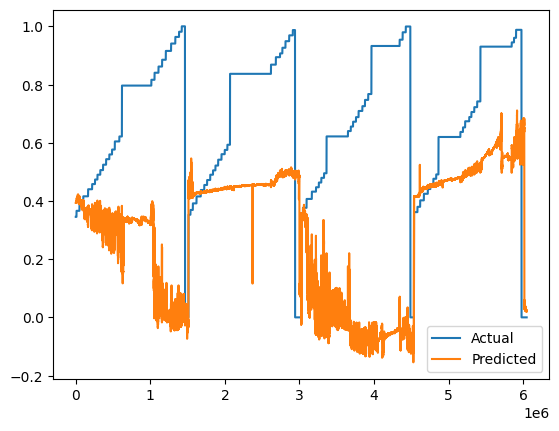

In [57]:
# Plot 

plt.plot(station_test, label='Actual')
plt.plot(station_pred, label='Predicted')
plt.legend()
plt.show()